In [ ]:
!pip install kaggle

# Create the .kaggle directory and move the JSON file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d datamunge/sign-language-mnist


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 97% 61.0M/62.6M [00:03<00:00, 22.6MB/s]
100% 62.6M/62.6M [00:03<00:00, 16.7MB/s]


In [ ]:
!unzip sign-language-mnist.zip


Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [ ]:
import torch
import cv2
import torch.nn as nn
from sklearn.metrics import f1_score
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
csv=  pd.read_csv('./sign_mnist_train.csv')
csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


<Axes: xlabel='label', ylabel='count'>

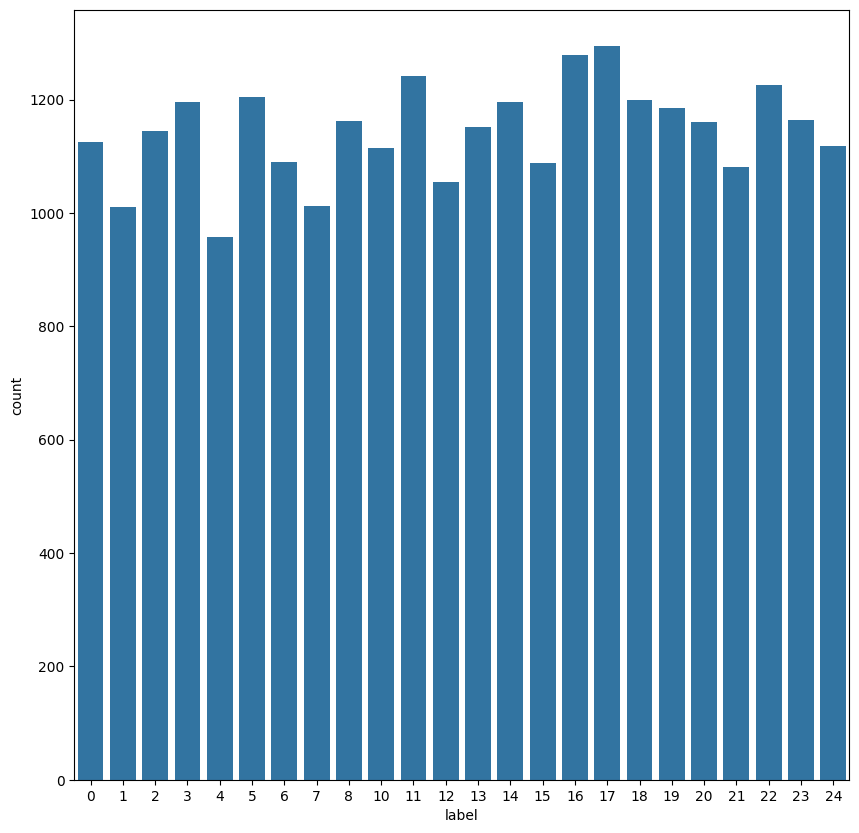

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='label', data=csv)

In [ ]:
test_csv = pd.read_csv('./sign_mnist_test.csv')
test_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
# Split the label (1st Column) and Image Pixels (2nd-785th Column)
text="pixel"
images=torch.zeros((csv.shape[0],1))
for i in range(1,785):
    temp_text=text+str(i)
    temp=csv[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1)
    images=torch.cat((images,temp),1)
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28)

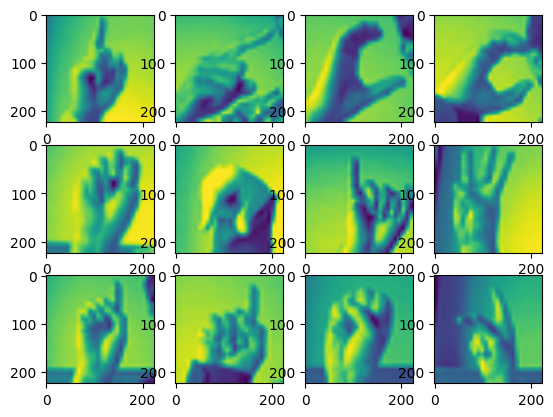

In [ ]:
fig = plt.figure(figure=(10,10))
columns = 3
rows = 4
for i in range(12):
  img = images_final[i]
  img = img.numpy()
  img = cv2.resize(img, (224,224))
  fig.add_subplot(columns,rows,i+1)
  plt.imshow(img)
plt.show()

In [ ]:
class GestureDataset(Dataset):
  def __init__(self, csv, train=True):
    self.csv= pd.read_csv(csv)
    self.img_size = 224

    self.train = train
    text = 'pixel'
    self.images = torch.zeros((self.csv.shape[0], 1))
    for i in range(1,785):
      temp_text = text + str(i)
      temp = self.csv[temp_text]
      temp = torch.FloatTensor(temp).unsqueeze(1)
      self.images = torch.cat((self.images, temp), 1)
    self.labels = self.csv['label']
    self.images = self.images[:,1:]
    self.images = self.images.view(-1,28,28)

  def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=cv2.resize(img,(self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image/=255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image,self.labels[index]
  def __len__(self):
        return self.images.shape[0]

In [ ]:
data= GestureDataset('./sign_mnist_train.csv')
data_val = GestureDataset('./sign_mnist_test.csv', train=False)

In [ ]:
train_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=64, shuffle=True)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.Conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5), # 220, 220
        nn.MaxPool2d(2), # 110, 110
        nn.ReLU(),
        nn.BatchNorm2d(32)
        )
        self.Conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5), # 106, 106
        nn.MaxPool2d(2),  # 53,53
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
        self.Conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3), # 51, 51
        nn.MaxPool2d(2), # 25, 25
        nn.ReLU(),
        nn.BatchNorm2d(128)
        )
        self.Conv4 = nn.Sequential(
        nn.Conv2d(128, 256, 3), # 23, 23
        nn.MaxPool2d(2), # 11, 11
        nn.ReLU(),
        nn.BatchNorm2d(256)
        )
        self.Conv5 = nn.Sequential(
        nn.Conv2d(256, 512, 3), # 9, 9
        nn.MaxPool2d(2), # 4, 4
        nn.ReLU(),
        nn.BatchNorm2d(512)
        )

        self.Linear1 = nn.Linear(512 * 4 * 4, 256)
        self.dropout=nn.Dropout(0.1)
        self.Linear3 = nn.Linear(256, 25)
    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x=self.dropout(x)
        x = self.Conv5(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# Instantiate the model, loss function, and optimizer
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training parameters
num_epochs = 9

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training loss
        train_loss += loss.item()

        # Store labels and predictions for accuracy and F1 calculation
        _, predicted = outputs.max(1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    # Calculate training metrics
    train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track validation loss
            val_loss += loss.item()

            # Store labels and predictions for accuracy and F1 calculation
            _, predicted = outputs.max(1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(all_val_labels, all_val_preds) * 100
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    # Print statistics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}")

Epoch 1/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.35it/s]


Epoch 1/9, Train Loss: 0.2072, Train Accuracy: 94.49%, Train F1: 0.9450, Val Loss: 0.4400, Val Accuracy: 90.85%, Val F1: 0.9058


Epoch 2/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.74it/s]


Epoch 2/9, Train Loss: 0.0010, Train Accuracy: 99.97%, Train F1: 0.9997, Val Loss: 0.2873, Val Accuracy: 94.07%, Val F1: 0.9403


Epoch 3/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 19.99it/s]


Epoch 3/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2844, Val Accuracy: 94.26%, Val F1: 0.9422


Epoch 4/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.67it/s]


Epoch 4/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2920, Val Accuracy: 94.31%, Val F1: 0.9427


Epoch 5/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 19.17it/s]


Epoch 5/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2841, Val Accuracy: 94.73%, Val F1: 0.9472


Epoch 6/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.84it/s]


Epoch 6/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2721, Val Accuracy: 94.67%, Val F1: 0.9465


Epoch 7/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 19.90it/s]


Epoch 7/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2855, Val Accuracy: 94.46%, Val F1: 0.9444


Epoch 8/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.09it/s]


Epoch 8/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2612, Val Accuracy: 94.98%, Val F1: 0.9496


Epoch 9/9 - Validation: 100%|██████████| 113/113 [00:05<00:00, 20.78it/s]

Epoch 9/9, Train Loss: 0.0000, Train Accuracy: 100.00%, Train F1: 1.0000, Val Loss: 0.2642, Val Accuracy: 95.04%, Val F1: 0.9501


In [ ]:

torch.save(model.state_dict(), 'model_state_dict.pth')

from google.colab import files
files.download('model_state_dict.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

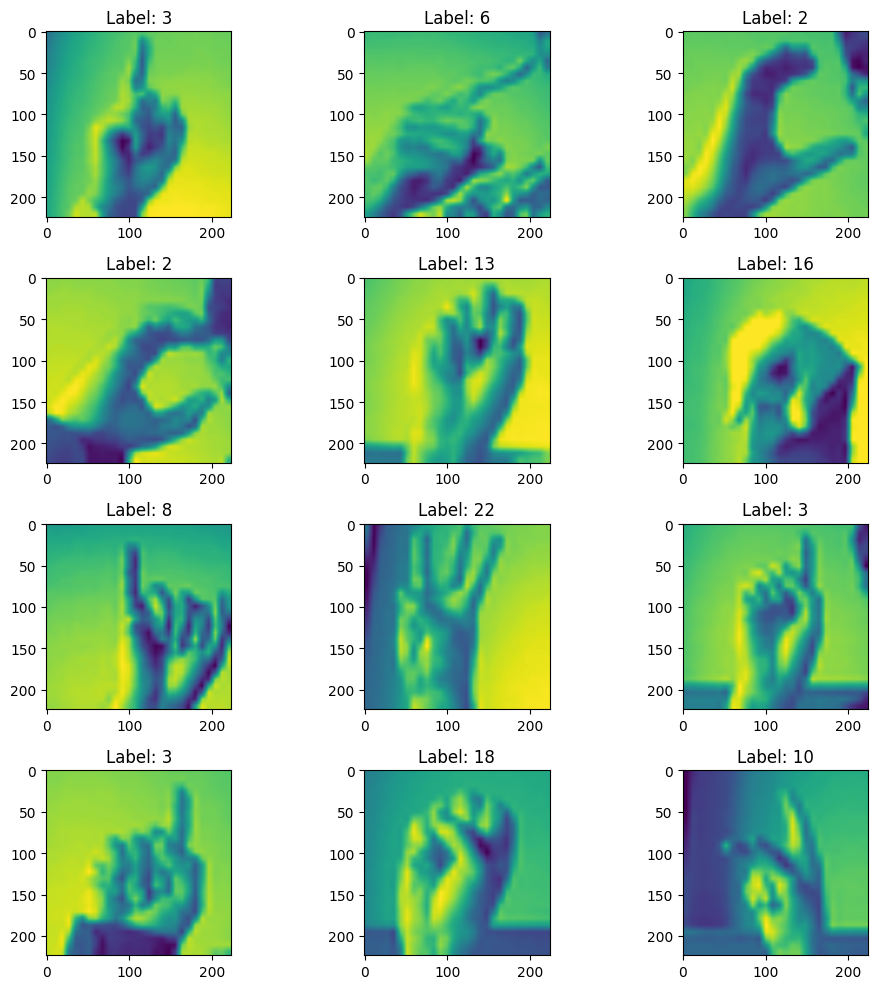

In [ ]:


fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 4
for i in range(12):
    img = images_final[i]
    img = img.numpy()
    img = cv2.resize(img, (224, 224))
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {csv['label'][i]}") #add label as title
plt.tight_layout() #adjust subplot params for a tight layout
plt.show()